In [139]:
import importlib
import json
import networkx as nx
from networkx.readwrite import json_graph
import numpy as np
import matplotlib.pyplot as plt
import requests
from gerrychain import Graph, Partition
from gerrychain.updaters import Tally, cut_edges
from graph_tools import *
from facefinder import *

In [140]:
link = "https://people.csail.mit.edu/ddeford//COUNTY/COUNTY_13.json"
g = graph_from_url(link)

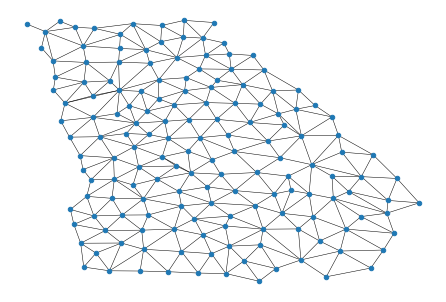

In [141]:
draw_with_location(g)

Need to remove nodes with degree one 

In [142]:
for v in g:
    if g.degree(v) == 1:
        print(v)

21


In [143]:
g.remove_node(21)

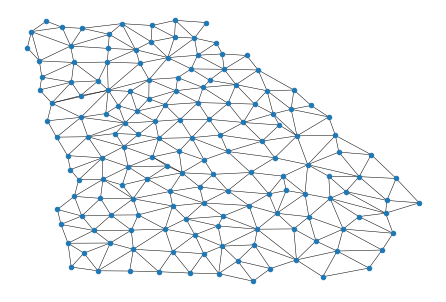

In [144]:
draw_with_location(g)

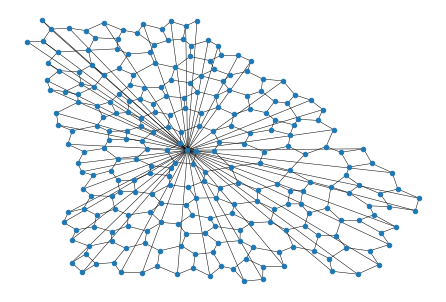

In [145]:
dual = restricted_planar_dual(g)
draw_with_location(dual)

Want to remove supernode for processing purposes.. may include in later analysis depending on use 

In [146]:
print(max(dict(dual.degree()).items(), key = lambda x : x[1]))

(frozenset({130, 3, 133, 7, 8, 9, 10, 138, 14, 144, 16, 146, 19, 22, 24, 154, 27, 157, 158, 31, 34, 36, 38, 40, 42, 46, 49, 52, 61, 64, 75, 77, 78, 81, 83, 84, 85, 87, 88, 93, 99, 108, 110, 116, 117, 121, 122, 125}), 48)


In [147]:
dual.degree(frozenset({3,7,8,9,10,14,16,19,22,24,27,31,34,36,38,40,42,46,49,52,61,64,75,77,78,
                       81,83,84,85,87,88,93,99,108,110,116,117,121,122,125,130,133,138,144,146,154,157,158}))

48

Add back in if need remove supernode 

dual.remove_node(frozenset({3,7,8,9,10,14,16,19,22,24,27,31,34,36,38,40,42,46,49,52,61,64,75,77,78,
                       81,83,84,85,87,88,93,99,108,110,116,117,121,122,125,130,133,138,144,146,154,157,158}))

dual.remove_node(frozenset({130, 3, 133, 7, 8, 9, 10, 138, 14, 144, 16, 146, 19, 21, 22, 24, 154, 27, 157, 158, 31, 
                            34, 36, 38, 40, 42, 46, 49, 52, 61, 64, 75, 77, 78, 81, 83, 84, 85, 87, 88, 93, 99, 108, 
                            110, 116, 117, 121, 122, 125}))

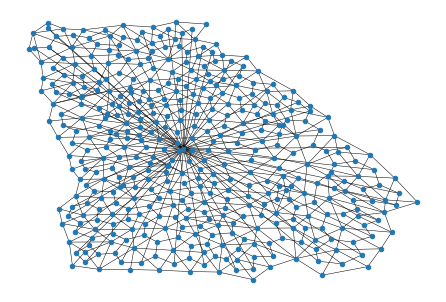

In [148]:
draw_with_location(dual)
draw_with_location(g)

CHANGE! vertical partition does not gurantee connected partitons. update to use spanning tree. gurantees connected.

In [149]:
vertical = []
for node in g.nodes():
    g.nodes[node]["pos"] = [g.node[node]["C_X"], g.node[node]["C_Y"]]
    vertical.append(g.nodes[node]["C_Y"])
mean_y_coord = sum(vertical) / len(vertical)

In [150]:
partition_y = build_partition(g,mean_y_coord)

In [151]:
for block in [-1,1]:
    subgraph = nx.subgraph(g, partition_y.parts[block])
    print(nx.is_connected(subgraph))

True
True


In [152]:
crosses = compute_cross_edge(g, partition_y)

In [153]:
dual_crosses = []
for edge in dual.edges:
    if dual.edges[edge]["original_name"] in crosses:
        dual_crosses.append(edge)   

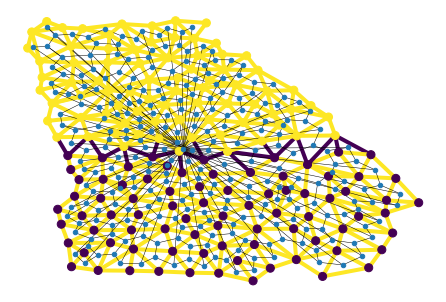

In [154]:
viz(g, crosses, partition_y.parts)
draw_with_location(dual)

In [155]:
def distance_from_partition(graph, boundary_edges):
#General Idea:
#Goal: Given any face of the original graph, want to calculate its distance to the boundary of the partition.
#Method: Treat that face as a vertex v of the dual graph D, and then (using above) treat the boundary of the partition of a set of vertices S of the dual graph. 
# Then calculate distance from v to S in D, using:
#d = infinity
#For each s in S:
 #    d = min ( distance_in_D(v,s), d)
    for node in graph.nodes():
        dist = 100000000
        for bound in boundary_edges:
            if node == bound[0] or node == bound[1]:
                dist = 0
            else:
                dist = min(dist, len(nx.shortest_path(graph, source = node, target = bound[0])) - 1)
                dist = min(dist, len(nx.shortest_path(graph, source = node, target = bound[1])) - 1)     
        graph.node[node]["distance"] = dist
    return graph

In [156]:
dual = distance_from_partition(dual, dual_crosses)

In [157]:
dual.node[frozenset({53, 6, 103})]

{'pos': array([-82.62471057,  32.90861498]), 'distance': 0}

In [158]:
for node in dual.nodes():
    print(dual.node[node]['distance'])

1
3
4
1
3
0
1
3
1
5
6
1
1
6
5
3
5
5
1
2
7
2
2
2
1
0
2
6
2
7
3
1
1
2
4
5
0
3
5
5
5
3
3
4
2
6
2
5
2
4
1
1
6
1
0
4
1
3
4
1
2
2
1
2
3
2
5
2
0
6
1
4
0
5
0
4
4
1
0
1
1
1
3
3
2
2
4
3
3
2
4
3
3
4
3
1
3
1
5
2
2
1
5
2
3
2
2
5
3
4
3
1
3
4
4
1
1
3
1
2
2
2
0
1
2
7
4
4
0
0
3
6
1
4
6
3
0
1
4
4
1
5
4
3
2
2
1
3
1
6
0
6
5
1
3
2
1
2
3
4
2
1
3
1
2
1
1
1
2
1
6
3
6
2
6
7
1
2
4
3
2
3
3
3
1
1
4
2
4
3
5
3
4
3
2
1
0
2
1
3
6
5
4
0
2
6
1
4
3
1
3
4
2
4
0
1
1
1
5
1
6
2
5
1
5
4
3
2
3
1
5
2
1
0
3
1
3
4
1
1
2
0
1
2
4
2
5
1
5
2
3
0
3
2
2
3
2
4
4
0
2


In [159]:
def viz(graph, edge_set, partition):
    values = [1 - int(x in edge_set) for x in graph.edges()]
    color_dictionary = {}
    for x in graph.nodes():
        if x in partition[-1]:
            color_dictionary[x] = 1
        else:
            color_dictionary[x] = 2
    distance_dictionary = {}
    for node in graph.nodes():
        distance_dictionary[node] = graph.node[node]['distance']
    node_values = [color_dictionary[x] for x in graph.nodes()]
    f = plt.figure()
    nx.draw(graph, pos=nx.get_node_attributes(graph, 'pos'), node_color = node_values, edge_color = values, labels = distance_dictionary, width = 4, node_size= 0, font_size = 7)

In [160]:
def draw_with_location(graph):
    '''
    draws graph with 'pos' as the xy coordinate of each nodes
    initialized by something like graph.nodes[x]["pos"] = np.array([x[0], x[1]])
    '''
    distance_dictionary = {}
    for node in graph.nodes():
        distance_dictionary[node] = graph.node[node]['distance']
    nx.draw(graph, pos=nx.get_node_attributes(graph, 'pos'), labels = distance_dictionary, node_size = 0, width = .5, cmap=plt.get_cmap('jet'))

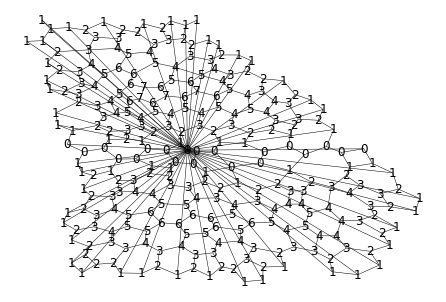

In [161]:
draw_with_location(dual)

idea, if a face is more than k away from a boundary, add edges 

In [162]:
def special_faces(graph, k):
    special_faces = []
    for node in graph.nodes():
        if graph.node[node]['distance'] >= k:
            special_faces.append(node)
    return special_faces

In [180]:
def face_refine(graph, special_faces):
    #graph must already have the face data computed
    #this adds a vetex in the middle of each face, and connects that vertex to the edges of that face...

    for face in special_faces:
        graph.add_node(face)
        location = np.array([0,0]).astype("float64")
        for v in face:
            graph.add_edge(face, v)
            location += np.array(graph.nodes[v]["pos"]).astype("float64")
        graph.nodes[face]["pos"] = location / len(face)
    return graph

In [186]:
g = face_refine(g, special_faces(dual,4))

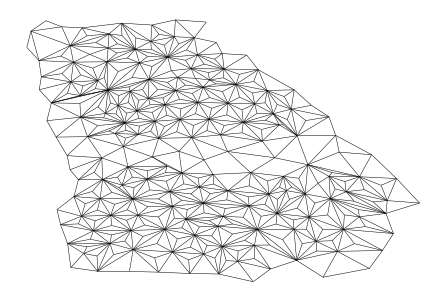

In [187]:
nx.draw(g, pos=nx.get_node_attributes(g, 'pos'), node_size = 0, width = .5, cmap=plt.get_cmap('jet'))

In [169]:
special[0]

frozenset({74, 91, 140})

In [170]:
for x in special[0]:
    print(x)

74
91
140


In [175]:
g.nodes[91]

{'boundary_node': False,
 'area': 0.06974662400249987,
 'STATEFP10': '13',
 'COUNTYFP10': '037',
 'COUNTYNS10': '00344074',
 'GEOID10': '13037',
 'NAME10': 'Calhoun',
 'NAMELSAD10': 'Calhoun County',
 'LSAD10': '06',
 'CLASSFP10': 'H1',
 'MTFCC10': 'G4020',
 'CSAFP10': '0',
 'CBSAFP10': '0',
 'METDIVFP10': 0,
 'FUNCSTAT10': 'A',
 'ALAND10': 726147317,
 'AWATER10': 8315704,
 'INTPTLAT10': '+31.5212790',
 'INTPTLON10': '-084.6262895',
 'POP10': 6694,
 'UPOP': 0.0,
 'RPOP': 6694,
 'C_X': -84.62450768595866,
 'C_Y': 31.529197278294202,
 'TOTPOP': 6694,
 'UTOTPOP': 0.0,
 'RTOTPOP': 6694,
 'NH_WHITE': 2250,
 'UNH_WHITE': 0.0,
 'RNH_WHITE': 2250,
 'NH_BLACK': 4092,
 'UNH_BLACK': 0.0,
 'RNH_BLACK': 4092,
 'NH_AMIN': 9,
 'UNH_AMIN': 0.0,
 'RNH_AMIN': 9,
 'NH_ASIAN': 30,
 'UNH_ASIAN': 0.0,
 'RNH_ASIAN': 30,
 'NH_NHPI': 0,
 'UNH_NHPI': 0.0,
 'RNH_NHPI': 0,
 'NH_OTHER': 2,
 'UNH_OTHER': 0.0,
 'RNH_OTHER': 2,
 'NH_2MORE': 49,
 'UNH_2MORE': 0.0,
 'RNH_2MORE': 49,
 'HISP': 262,
 'UHISP': 0.0,
 'RHISP

In [179]:
dual[frozenset({74, 91, 140})]['pos']

KeyError: 'pos'